<!-- 🚀🚀🚀 Stock Price Prediction for AAPL (2015–2023) 🚀🚀🚀 -->

[![Python](https://img.shields.io/badge/Python-3.8%2B-blue)](https://www.python.org/)  
[![TensorFlow](https://img.shields.io/badge/TensorFlow-2.x-orange)](https://www.tensorflow.org/)  
[![yfinance](https://img.shields.io/badge/yfinance-latest-brightgreen)](https://pypi.org/project/yfinance/)  

---

# 📊 Stock Price Prediction for AAPL (2015–2023)

### **Overview**  
A step‑by‑step pipeline to forecast Apple Inc. (AAPL) closing prices from 2015 through 2023 using an LSTM model.  
Key phases:  
1. Data Acquisition  
2. Feature Engineering  
3. Visualization  
4. Data Preparation  
5. Model Training  
6. Evaluation  


In [1]:
pip install yfinance pandas ta scikit-learn matplotlib

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=6bd21f6a03b335339d456bffdcc52ea7d24a07c1d1bc7cf8745dadb64ce37e51
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta
Note: you may need to restart the kernel to use updated packages.


## Imports  
Organize your imports into:  
- 🔹 **Built‑in** modules  
- 🔹 **Third‑party** libraries  
- 🔹 **Specialized** packages  


In [2]:
import datetime
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import yfinance as yf
import ta  # technical analysis indicators

import sklearn.preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential

import xgboost as xgb

2025-07-11 15:45:37.907045: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752248738.160263      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752248738.234906      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Data Download  
- **Source:** Yahoo Finance  
- **Period:** 2015‑01‑01 → 2023‑12‑31  
- **Features:**  
  - Open  
  - High  
  - Low  
  - Close  
  - Volume  

In [3]:
# Download daily price data for AAPL from 2015 to end of 2023
df = yf.download('AAPL', start='2015-01-01', end='2024-01-01')

# Keep only the core OHLCV features
df = df[['Open', 'High', 'Low', 'Close', 'Volume']]

/tmp/ipykernel_13/3646088207.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('AAPL', start='2015-01-01', end='2024-01-01')
[*********************100%***********************]  1 of 1 completed


## Feature Engineering  
Enhance raw OHLCV data with key technical indicators:

### Simple Moving Average (10‑day)  
_Smooths short‑term volatility and highlights longer trends._

### Relative Strength Index (14‑day)  
_Measures momentum to flag overbought/oversold conditions._

### ➖ Drop Missing Values  
_Remove initial NaNs introduced by rolling/window calculations._

---

In [4]:
# Simple Moving Average (10-day)
df['MA_10'] = df['Close'].rolling(window=10, min_periods=10).mean()

# Relative Strength Index (14-day)
#    RSIIndicator returns a pandas Series; .rsi() fetches the indicator values
rsi_indicator = ta.momentum.RSIIndicator(close=df['Close'].squeeze(), window=14)
df['RSI_14'] = rsi_indicator.rsi()

# Drop initial rows that contain NaNs due to indicator windows
df.dropna(inplace=True)

/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)


## Quick Data Peek  
- **Action:** Display the first few rows  
- **Purpose:** Verify data integrity and structure  


In [5]:
print("Data snapshot:")
print(df.head())
print("\nShape:", df.shape)

Data snapshot:
Price            Open       High        Low      Close     Volume      MA_10  \
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL              
Date                                                                           
2015-01-22  24.495189  24.986159  24.375223  24.970608  215185600  24.363005   
2015-01-23  24.948391  25.270520  24.777328  25.099459  185859200  24.387220   
2015-01-26  25.268295  25.406034  25.059467  25.126114  222460000  24.411434   
2015-01-27  24.975050  24.988380  24.221933  24.246370  382274800  24.408990   
2015-01-28  26.132492  26.241351  25.617085  25.617085  585908400  24.522068   

Price          RSI_14  
Ticker                 
Date                   
2015-01-22  60.986442  
2015-01-23  62.490140  
2015-01-26  62.809483  
2015-01-27  48.218527  
2015-01-28  62.741592  

Shape: (2251, 7)


## Visualization: Prices & Volume  
Create two clear subplots:

### 📈 Price Plot  
Visualize **Open**, **High**, **Low**, **Close** over time (2015–2023).

### 📊 Volume Plot  
Show trading **volume** trends for the same period.


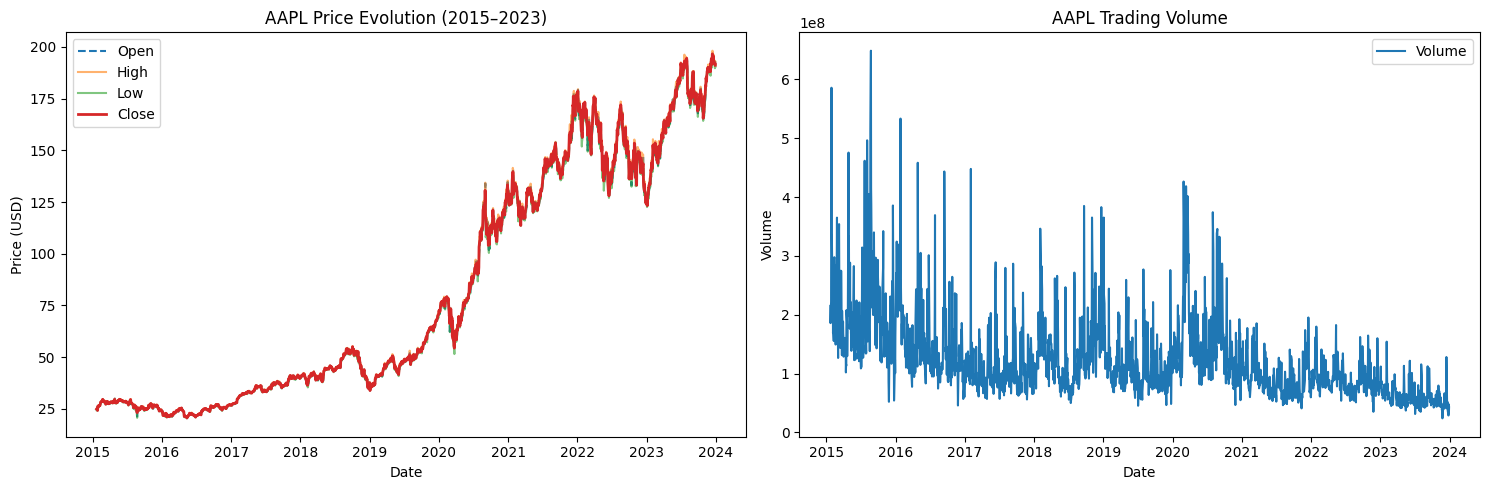

In [6]:
plt.figure(figsize=(15, 5))

# Price plot
plt.subplot(1, 2, 1)
plt.plot(df.index, df['Open'],  label='Open',  linestyle='--')
plt.plot(df.index, df['High'],  label='High',   alpha=0.6)
plt.plot(df.index, df['Low'],   label='Low',    alpha=0.6)
plt.plot(df.index, df['Close'], label='Close',  linewidth=2)
plt.title('AAPL Price Evolution (2015–2023)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()

# Volume plot
plt.subplot(1, 2, 2)
plt.plot(df.index, df['Volume'], label='Volume')
plt.title('AAPL Trading Volume')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()

plt.tight_layout()
plt.show()

## Prepare Data for Modeling  

### Select Features  
- Open  
- High  
- Low  
- Close  
- Volume  
- MA_10  
- RSI_14  

### Scale Features  
_Normalize values to [0, 1] via Min‑Max scaling for stable learning._


In [7]:
# Select features for the model
FEATURE_COLUMNS = ['Open', 'High', 'Low', 'Close', 'Volume', 'MA_10', 'RSI_14']
data = df[FEATURE_COLUMNS].values  # as NumPy array

# Scale features to [0, 1] using Min-Max scaling
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

## Sequence Generator Function  
- **Window size:** 60 days  
- **Target:** Next‑day Close price  
- **Output:**  
  - **X:** 60×7 feature sequences  
  - **y:** single Close value  

In [8]:
def create_sequences(
    data: np.ndarray,
    seq_len: int = 60,
    target_col_idx: int = 3
) -> tuple[np.ndarray, np.ndarray]:
    """
    Convert the time series data into sequences for LSTM:
      - X: sequences of length `seq_len` (each sequence is seq_len × num_features)
      - y: next-day target (the 'Close' price at index seq_len + i)
    
    Args:
        data           : numpy array of shape (n_samples, n_features)
        seq_len        : length of the input sequence (default 60 days)
        target_col_idx : which column to predict (default index 3 → 'Close')
    
    Returns:
        X : np.ndarray of shape (n_samples−seq_len−1, seq_len, n_features)
        y : np.ndarray of shape (n_samples−seq_len−1,)
    """
    X, y = [], []
    for i in range(seq_len, len(data) - 1):
        X.append(data[i - seq_len:i, :])
        # The label is the day AFTER the end of the sequence
        y.append(data[i + 1, target_col_idx])
    return np.array(X), np.array(y)

# Generate sequences (60-day windows predicting next day's Close)
SEQ_LEN = 60
X, y = create_sequences(scaled_data, seq_len=SEQ_LEN)

## Train / Validation / Test Split  
- **Train:** 70%  
- **Validation:** 15%  
- **Test:** 15%  
_Ensures robust performance evaluation on unseen data._

In [9]:
n = len(X)
train_end = int(0.70 * n)
val_end   = train_end + int(0.15 * n)

X_train, y_train = X[:train_end], y[:train_end]
X_val,   y_val   = X[train_end:val_end], y[train_end:val_end]
X_test,  y_test  = X[val_end:], y[val_end:]

print(f"Dataset sizes → Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

Dataset sizes → Train: 1533, Val: 328, Test: 329


## Build the LSTM Model  
- **Architecture:**  
  - 2× LSTM layers (64 units each)  
  - Dropout (20%) to prevent overfitting  
  - Dense output layer for single‑step forecast  
- **Compile:** Adam optimizer + MSE loss  

In [10]:
model = Sequential([
    # First LSTM layer returns sequences so we can stack another LSTM
    LSTM(64, return_sequences=True, input_shape=(SEQ_LEN, X.shape[2])),
    Dropout(0.2),
    # Second LSTM layer outputs a vector of size 64
    LSTM(64),
    Dropout(0.2),
    # Final dense layer predicts a single value (next-day Close price)
    Dense(1, activation='linear')
])

model.compile(optimizer='adam', loss='mse')
model.summary()

2025-07-11 15:45:56.099373: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 64)         │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,521 (201.25 KB)

 Trainable params: 51,521 (201.25 KB)

 Non-trainable params: 0 (0.00 B)

## Train the Model  
- **Epochs:** 50  
- **Batch size:** 32  
- **Monitors:** Training & validation loss for convergence  


In [11]:
EPOCHS = 50
BATCH_SIZE = 32

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=2
)

Epoch 1/50
48/48 - 9s - 186ms/step - loss: 0.0058 - val_loss: 0.0020
Epoch 2/50
48/48 - 3s - 61ms/step - loss: 9.8107e-04 - val_loss: 0.0022
Epoch 3/50
48/48 - 3s - 58ms/step - loss: 8.3757e-04 - val_loss: 0.0019
Epoch 4/50
48/48 - 3s - 57ms/step - loss: 8.8993e-04 - val_loss: 0.0012
Epoch 5/50
48/48 - 3s - 58ms/step - loss: 7.5240e-04 - val_loss: 0.0011
Epoch 6/50
48/48 - 3s - 57ms/step - loss: 8.1656e-04 - val_loss: 0.0050
Epoch 7/50
48/48 - 3s - 57ms/step - loss: 6.2339e-04 - val_loss: 0.0035
Epoch 8/50
48/48 - 3s - 58ms/step - loss: 6.7225e-04 - val_loss: 0.0022
Epoch 9/50
48/48 - 3s - 58ms/step - loss: 6.9739e-04 - val_loss: 0.0010
Epoch 10/50
48/48 - 3s - 57ms/step - loss: 6.8192e-04 - val_loss: 0.0012
Epoch 11/50
48/48 - 3s - 57ms/step - loss: 6.1857e-04 - val_loss: 0.0031
Epoch 12/50
48/48 - 3s - 57ms/step - loss: 5.6460e-04 - val_loss: 0.0032
Epoch 13/50
48/48 - 3s - 56ms/step - loss: 5.2395e-04 - val_loss: 9.7677e-04
Epoch 14/50
48/48 - 3s - 60ms/step - loss: 7.4590e-04 - val

## Invert Scaling to Original Price Space  
_Reconstruct USD prices from normalized predictions for interpretability._


In [12]:
def invert_scale(scaled_vals: np.ndarray, col_idx: int = 3) -> np.ndarray:
    """
    Inverse-transform the scaled values for the given target column.
    We build a dummy matrix to match the scaler's expected input shape.
    """
    # Create dummy array: zeros for all other features, insert our column of interest
    dummy = np.zeros((len(scaled_vals), data.shape[1]))
    dummy[:, col_idx] = scaled_vals.ravel()
    # Inverse transform entire array, then extract target column
    inv = scaler.inverse_transform(dummy)
    return inv[:, col_idx]

# Predict on each split
pred_train = model.predict(X_train)
pred_val   = model.predict(X_val)
pred_test  = model.predict(X_test)

# Convert scaled predictions & true labels back to USD
y_train_real = invert_scale(y_train)
y_val_real   = invert_scale(y_val)
y_test_real  = invert_scale(y_test)

pred_train_real = invert_scale(pred_train)
pred_val_real   = invert_scale(pred_val)
pred_test_real  = invert_scale(pred_test)

48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


## Generate Predictions & Visualization  

### Generate Predictions  
- **Train set:** predict with `model.predict(X_train)`  
- **Validation set:** predict with `model.predict(X_val)`  
- **Test set:** predict with `model.predict(X_test)`

### Assemble Full Series  
- **True values:** concatenate `y_train_real`, `y_val_real`, `y_test_real`  
- **Predictions:** concatenate `pred_train_real`, `pred_val_real`, `pred_test_real`

### Full Series Plot  
Visualize actual vs. predicted Close across **train + val + test** in one subplot.

### Test Set Zoom  
Zoom in on the **test** segment to assess out‑of‑sample forecasting accuracy.


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


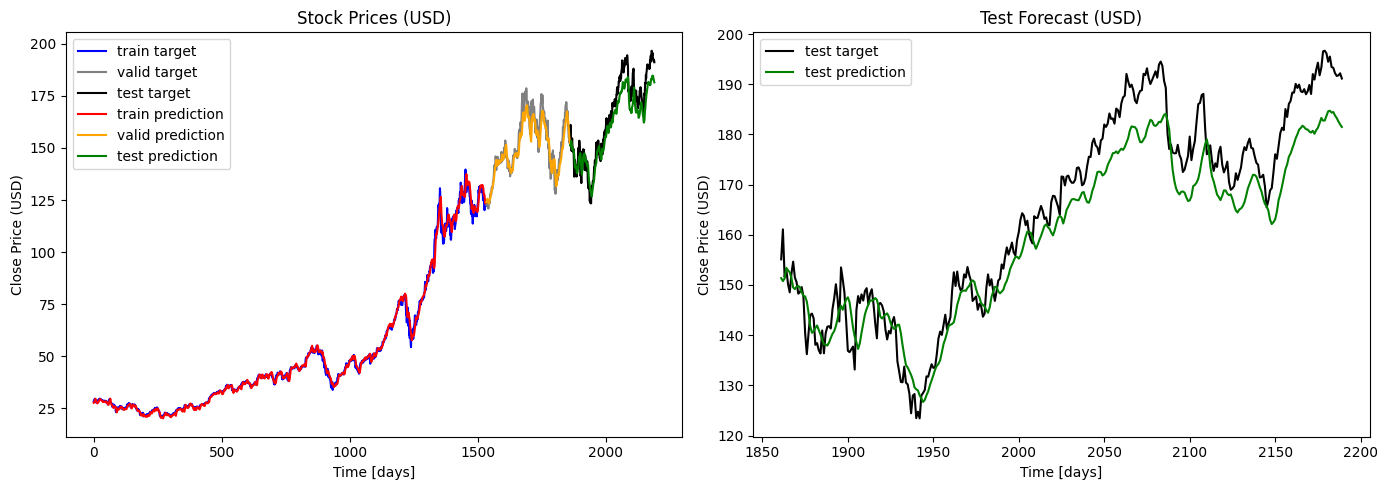

In [13]:
pred_train = model.predict(X_train)
pred_val = model.predict(X_val)
pred_test = model.predict(X_test)


all_targets_real = np.concatenate([y_train_real, y_val_real, y_test_real])
all_preds_real = np.concatenate([pred_train_real, pred_val_real, pred_test_real])

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(range(len(y_train_real)), y_train_real, label="train target", color='blue')
plt.plot(range(len(y_train_real), len(y_train_real) + len(y_val_real)), y_val_real, label="valid target", color='gray')
plt.plot(range(len(y_train_real) + len(y_val_real), len(all_targets_real)), y_test_real, label="test target", color='black')

plt.plot(range(len(y_train_real)), pred_train_real, label="train prediction", color='red')
plt.plot(range(len(y_train_real), len(y_train_real) + len(y_val_real)), pred_val_real, label="valid prediction", color='orange')
plt.plot(range(len(y_train_real) + len(y_val_real), len(all_targets_real)), pred_test_real, label="test prediction", color='green')

plt.title('Stock Prices (USD)')
plt.xlabel('Time [days]')
plt.ylabel('Close Price (USD)')
plt.legend()


plt.subplot(1, 2, 2)
start = len(y_train_real) + len(y_val_real)
end = len(all_targets_real)
plt.plot(range(start, end), y_test_real, label="test target", color='black')
plt.plot(range(start, end), pred_test_real, label="test prediction", color='green')
plt.title('Test Forecast (USD)')
plt.xlabel('Time [days]')
plt.ylabel('Close Price (USD)')
plt.legend()

plt.tight_layout()
plt.show()

## Evaluate Performance with MAE & RMSE  
Quantify prediction errors (in USD):  
- **MAE:** Mean Absolute Error  
- **RMSE:** Root Mean Squared Error  


In [14]:
# =============================================================================
# 14. Evaluate Performance with MAE and RMSE
# =============================================================================
def report_metrics(true_vals, pred_vals, label=""):
    mae  = mean_absolute_error(true_vals, pred_vals)
    rmse = math.sqrt(mean_squared_error(true_vals, pred_vals))
    print(f"{label:10s} MAE: {mae:8.2f} | RMSE: {rmse:8.2f}")

print("\nPerformance Metrics (USD):")
report_metrics(y_train_real, pred_train_real, label="Train")
report_metrics(y_val_real,   pred_val_real,   label="Val")
report_metrics(y_test_real,  pred_test_real,  label="Test")


Performance Metrics (USD):
Train      MAE:     1.20 | RMSE:     1.98
Val        MAE:     3.81 | RMSE:     5.13
Test       MAE:     5.75 | RMSE:     6.76


---
---
---
---
---
---
---
✨ **End of Workflow** ✨
